## Notebook to report descriptive statistics from demoraphic and assessment data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

### Paths


In [106]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy release
current_release = "qpn-nipoppy-R1"

data_release_dir = f"{DATASET_ROOT}/releases/{current_release}/"
tabular_data_release_dir = f"{data_release_dir}/tabular/"
manifest_file = f"{data_release_dir}/manifest.csv"

# tabular files
demographics_file = f"{tabular_data_release_dir}/demographics.csv"
mri_session_date_file = f"{tabular_data_release_dir}/mri_info/mri_sessions.csv"
updrs_file = f"{tabular_data_release_dir}/assessments/updrs.csv"
hy_file = f"{tabular_data_release_dir}/assessments/hy.csv"
moca_file = f"{tabular_data_release_dir}/assessments/moca.csv"
dx_file = f"{tabular_data_release_dir}/assessments/diagnosis.csv"
neuropsych_file = f"{tabular_data_release_dir}/assessments/neuropsych.csv"

### Defs

In [199]:
def subset_and_replace_df(df, filters_dict, rename_dict):
    """ Subset rows and replace columns values in a dataframe
    """
    for col, val_list in filters_dict.items():
        df = df[df[col].isin(val_list)].copy()

    for col, val_list in rename_dict.items():
        df[col] = df[col].replace(val_list).copy()

    return df
    


def get_group_table_stats(df, cat_cols, score_cols, groupby_col="redcap_event_name"):
    """ Get table stats for groups. Does not stratify by group! 
    """
    n_cat_cols = len(cat_cols)
    n_score_cols = len(score_cols)
    print(f"Counting {n_cat_cols} and averaging {n_score_cols}")

    table_df = df[groupby_col].value_counts().reset_index()
    print("Starting cat cols")
    for col in cat_cols:
        # print(f"col: {col}")
        cat_count_df = df.groupby([groupby_col])[col].value_counts().unstack().reset_index()
        table_df = pd.merge(table_df, cat_count_df, on=groupby_col, how="left")

    print("Starting score cols")
    for col in score_cols:
        # print(f"col: {col}")
        score_count = df.groupby([groupby_col])[col].count()
        score_mean_df = df.groupby([groupby_col])[col].mean().round(1)
        score_std_df = df.groupby([groupby_col])[col].std().round(1)
        score_min_df = df.groupby([groupby_col])[col].min().round(2)
        score_max_df = df.groupby([groupby_col])[col].max().round(2)
        score_mean_std_df = "(N=" + score_count.astype(str) + ") " + score_mean_df.astype(str) + " (" + score_std_df.astype(str) + ")" + " ["  \
        + score_min_df.astype(str) + ", " + score_max_df.astype(str) + "]"
        score_mean_std_df = score_mean_std_df.reset_index()
        # score_mean_std_df["non-null-count"] = score_count
        table_df = pd.merge(table_df, score_mean_std_df, on=groupby_col, how="left")
    
    return table_df

### Load data

In [158]:
manifest_df = pd.read_csv(manifest_file)
demo_df = pd.read_csv(demographics_file)
mri_df = pd.read_csv(mri_session_date_file)
hy_df = pd.read_csv(hy_file)
updrs_df = pd.read_csv(updrs_file)
moca_df = pd.read_csv(moca_file)
dx_df = pd.read_csv(dx_file)
neuropsy_df = pd.read_csv(neuropsych_file)

dx_df = dx_df[['participant_id', 'redcap_event_name','diagnosis_group_for_analysis']].copy()


### QPN paper tables

In [159]:
# paper subset filters
cohort_inclusion_list = ["QPN"]
# group_inclusion_list = ["Healthy control/Contrôle", "PD   (Parkinson's Disease)/Maladie de Parkinson"]
dx_inclusion_list = ["PD", "control"]
visits_inclusion_list = ["Baseline (Arm 1: C-OPN)", "legacy-updrs3", "legacy-moca"]
session_inclusion_list = ["ses-01"]

participant_inclusion_criteria = {
    "redcap_event_name" : visits_inclusion_list, 
    "recruitment_cohort": cohort_inclusion_list,
    "diagnosis_group_for_analysis": dx_inclusion_list,
    "session": session_inclusion_list
    }

# QPN_groups = {"Healthy control/Contrôle": "control", "PD   (Parkinson's Disease)/Maladie de Parkinson": "PD", np.NaN:"Unknown"}
QPN_sexes = {"Female/Féminin": "Female", "Male/Masculin":"Male"}

col_val_replacement_criteria = {
    # "enrollment_group": QPN_groups,
    "sex": QPN_sexes
}

### Manifest

In [160]:
paper_df = pd.merge(manifest_df, demo_df, on="participant_id", how="left")
paper_df = pd.merge(paper_df, dx_df, on=["participant_id","redcap_event_name"], how="left")

n_tabular_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

# Filter and replace values
paper_df = subset_and_replace_df(paper_df, participant_inclusion_criteria, col_val_replacement_criteria)
n_paper_participants = paper_df["participant_id"].nunique()
print(f"Number of participants after event and group filter: {n_paper_participants}")

session_counts = paper_df["session"].value_counts()
print(f"session_counts: {session_counts}")

paper_df.head()

Number of participants: 306
Number of participants after event and group filter: 271
session_counts: session
ses-01    271
Name: count, dtype: int64


,participant_id,visit,session,datatype,dicom_availabilty,redcap_event_name,recruitment_cohort,enrollment_group,sex,education,diagnosis_group_for_analysis
0,MNI0215,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,Healthy control/Contrôle,Female,19,control
1,PD01145,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD (Parkinson's Disease)/(Maladie de Parkinson),Male,14,PD
2,MNI0313,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,Healthy control/Contrôle,Male,NaN,control
3,MNI0476,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD (Parkinson's Disease)/(Maladie de Parkinson),Female,11,PD
4,PD01214,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD (Parkinson's Disease)/(Maladie de Parkinson),Female,15,PD


#### Demo table
- Add MRI age column

In [161]:
# add mri_age column
paper_mri_df = pd.merge(paper_df, mri_df[["participant_id", "redcap_event_name", "MRI_age"]], on=["participant_id", "redcap_event_name"], how="left")

n_tabular_participants = paper_mri_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

# Filter and replace values
paper_mri_df = subset_and_replace_df(paper_mri_df, participant_inclusion_criteria, col_val_replacement_criteria)
n_paper_participants = paper_mri_df["participant_id"].nunique()
print(f"Number of participants after event and group filter: {n_paper_participants}")

redcap_events = paper_mri_df["redcap_event_name"].unique()
print(f"redcap events: {redcap_events}")

paper_mri_df.head()

Number of participants: 271
Number of participants after event and group filter: 271
redcap events: ['Baseline (Arm 1: C-OPN)']


,participant_id,visit,session,datatype,dicom_availabilty,redcap_event_name,recruitment_cohort,enrollment_group,sex,education,diagnosis_group_for_analysis,MRI_age
0,MNI0215,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,Healthy control/Contrôle,Female,19,control,66.93
1,PD01145,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD (Parkinson's Disease)/(Maladie de Parkinson),Male,14,PD,78.85
2,MNI0313,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,Healthy control/Contrôle,Male,NaN,control,73.55
3,MNI0476,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD (Parkinson's Disease)/(Maladie de Parkinson),Female,11,PD,74.24
4,PD01214,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD (Parkinson's Disease)/(Maladie de Parkinson),Female,15,PD,51.59


In [162]:
# counts
cat_cols = ["sex"]
score_cols = ["MRI_age"]

for dx in dx_inclusion_list:
    print(f"*** dx: {dx} ***")
    dx_group_df = paper_mri_df[paper_mri_df["diagnosis_group_for_analysis"]==dx].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** dx: PD ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
         redcap_event_name  count  Female  Male  \
0  Baseline (Arm 1: C-OPN)    202      67   135   

                                       MRI_age  
0  non-null-count: 202 65.5 (9.0) [40.8, 88.3]  
----------
*** dx: control ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
         redcap_event_name  count  Female  Male  \
0  Baseline (Arm 1: C-OPN)     69      44    25   

                                       MRI_age  
0  non-null-count: 69 62.6 (11.9) [26.0, 83.0]  
----------


#### H&Y scores

In [228]:
H_Y_stage_dict = dict(zip(
    [
    '(2) Bilateral involvement without impairment of balance',
    '(3) Bilateral disease: mild to moderate disability with impaired postural reflexes; physically independent; needs assistance to recover from pull test',
    '(1) Unilateral involvement only, usually with minimal or no functional disability',
    '(0) Asymptomatic',
    '(4) Severely disabling disease; still able to walk or stand unassisted',
    np.nan], 
    
    ['2', '3', '1', '0', '4', "N/A"]
))

hy_df["H_Y_stage"] = hy_df['Hoehn and Yahr Stage: '].replace(H_Y_stage_dict).copy()
hy_df = hy_df[hy_df["H_Y_stage"]!="N/A"]

cat_cols = ["H_Y_stage"]
score_cols = []

hy_participants = hy_df["participant_id"].nunique()
hy_event_counts = hy_df["redcap_event_name"].value_counts()

print(f"updrs_participants: {hy_participants}")
print(f"updrs_event_counts: {hy_event_counts}")

paper_hy_df = pd.merge(dx_df.drop(columns=["redcap_event_name"]), hy_df, on=["participant_id"], how="right")


for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_group_df = paper_hy_df[paper_hy_df["diagnosis_group_for_analysis"]==dx_group].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols, groupby_col="diagnosis_group_for_analysis")
    print("-"*10)
    print(table_df)
    print("-"*10)


updrs_participants: 95
updrs_event_counts: redcap_event_name
Baseline (Arm 1: C-OPN)                     89
12 Months Follow-Up/Suivi (Arm 1: C-OPN)     5
legacy-updrs3                                1
Name: count, dtype: int64
*** group: PD ***
Counting 1 and averaging 0
Starting cat cols
Starting score cols
----------
  diagnosis_group_for_analysis  count   1   2  3  4
0                           PD     95  25  63  5  2
----------
*** group: control ***
Counting 1 and averaging 0
Starting cat cols
Starting score cols
----------
Empty DataFrame
Columns: [count, diagnosis_group_for_analysis]
Index: []
----------


#### UPDRS table

In [229]:
updrs_participants = updrs_df["participant_id"].nunique()
updrs_event_counts = updrs_df["redcap_event_name"].value_counts()

print(f"updrs_participants: {updrs_participants}")
print(f"updrs_event_counts: {updrs_event_counts}")

paper_updrs_df = pd.merge(dx_df.drop(columns=["redcap_event_name"]), updrs_df, on=["participant_id"], how="right")

cat_cols = []
score_cols = ["Part III: Motor Examination"]

for dx in dx_inclusion_list:
    print(f"*** dx: {dx} ***")
    dx_group_df = paper_updrs_df[paper_updrs_df["diagnosis_group_for_analysis"]==dx].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols, groupby_col="diagnosis_group_for_analysis")
    print("-"*10)
    print(table_df)
    print("-"*10)


paper_updrs_df.head()

updrs_participants: 142
updrs_event_counts: redcap_event_name
Baseline (Arm 1: C-OPN)                     112
legacy-updrs3                                25
12 Months Follow-Up/Suivi (Arm 1: C-OPN)      5
Name: count, dtype: int64
*** dx: PD ***
Counting 0 and averaging 1
Starting cat cols
Starting score cols
----------
  diagnosis_group_for_analysis  count      Part III: Motor Examination
0                           PD    142  (N=142) 29.6 (13.5) [5.0, 72.0]
----------
*** dx: control ***
Counting 0 and averaging 1
Starting cat cols
Starting score cols
----------
Empty DataFrame
Columns: [count, diagnosis_group_for_analysis, Part III: Motor Examination]
Index: []
----------


,participant_id,diagnosis_group_for_analysis,redcap_event_name,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Updrs_3_1 value,Updrs_3_2 value,Updrs_3_3_neck value,Updrs_3_3_rue value,Updrs_3_3_lue value,...,Updrs_3_17_rle value,Updrs_3_17_lle value,Updrs_3_17_lipjaw value,Updrs_3_18 value,Part III: Motor Examination,Part III: Motor Examination (harmonized),Part IV: Motor Complications,updrs_age,updrs_age_diff,updrs_age_diff_abs
0,MNI0056,PD,Baseline (Arm 1: C-OPN),12.0,22.0,2.0,2.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,58.0,58.0,0.0,79.06,-2.16,2.16
1,MNI0058,PD,Baseline (Arm 1: C-OPN),0.0,6.0,0.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,1.0,26.0,26.0,0.0,57.36,-0.84,0.84
2,MNI0079,PD,Baseline (Arm 1: C-OPN),13.0,10.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,22.0,22.0,8.0,50.16,0.96,0.96
3,MNI0103,PD,Baseline (Arm 1: C-OPN),28.0,25.0,2.0,2.0,3.0,2.0,2.0,...,0.0,0.0,0.0,0.0,43.0,43.0,NaN,82.12,-1.32,1.32
4,MNI0109,PD,Baseline (Arm 1: C-OPN),6.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,7.0,7.0,0.0,45.31,0.00,0.00


### MoCA score

In [246]:
moca_participants = moca_df["participant_id"].nunique()
moca_event_counts = moca_df["redcap_event_name"].value_counts()

print(f"moca_participants: {moca_participants}")
print(f"moca_event_counts: {moca_event_counts}")

moca_score_col = "TOTAL SCORE (make sure to include extra point for 12 years or less of education):    SCORE TOTAL (assurez-vous d'inclure un point supplémentaire pour 12 ans ou moins d'éducation) : "

cog_subtype_col = "cog_subgroup"
paper_moca_df = pd.merge(dx_df.drop(columns=["redcap_event_name"]), moca_df, on=["participant_id"], how="right")
paper_moca_df.loc[paper_moca_df[moca_score_col] >= 26, cog_subtype_col] = "CN" 
paper_moca_df.loc[(paper_moca_df[moca_score_col] >= 21) & (paper_moca_df[moca_score_col] < 26), cog_subtype_col] = "MCI"
paper_moca_df.loc[paper_moca_df[moca_score_col] < 21, cog_subtype_col] = "Dementia"

paper_moca_df = paper_moca_df.rename(columns={moca_score_col: "moca_total"}).copy()

cat_cols = []
score_cols = ["moca_total"]

for dx in dx_inclusion_list:
    print(f"*** dx: {dx} ***")
    dx_group_df = paper_moca_df[paper_moca_df["diagnosis_group_for_analysis"]==dx].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols, groupby_col=cog_subtype_col)
    print("-"*10)
    print(table_df)
    print("-"*10)


paper_updrs_df.head()

moca_participants: 197
moca_event_counts: redcap_event_name
Baseline (Arm 1: C-OPN)                     180
12 Months Follow-Up/Suivi (Arm 1: C-OPN)     10
legacy-moca                                   7
Name: count, dtype: int64
*** dx: PD ***
Counting 0 and averaging 1
Starting cat cols
Starting score cols
----------
  cog_subgroup  count                      moca_total
0           CN     69  (N=69) 27.9 (1.4) [26.0, 30.0]
1          MCI     64  (N=64) 23.5 (1.3) [21.0, 25.0]
2     Dementia     16  (N=16) 18.3 (1.8) [14.0, 20.0]
----------
*** dx: control ***
Counting 0 and averaging 1
Starting cat cols
Starting score cols
----------
  cog_subgroup  count                      moca_total
0           CN     33  (N=33) 28.2 (1.4) [26.0, 30.0]
1          MCI     14  (N=14) 23.6 (1.3) [21.0, 25.0]
2     Dementia      1   (N=1) 16.0 (nan) [16.0, 16.0]
----------


,participant_id,diagnosis_group_for_analysis,redcap_event_name,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Updrs_3_1 value,Updrs_3_2 value,Updrs_3_3_neck value,Updrs_3_3_rue value,Updrs_3_3_lue value,...,Updrs_3_17_rle value,Updrs_3_17_lle value,Updrs_3_17_lipjaw value,Updrs_3_18 value,Part III: Motor Examination,Part III: Motor Examination (harmonized),Part IV: Motor Complications,updrs_age,updrs_age_diff,updrs_age_diff_abs
0,MNI0056,PD,Baseline (Arm 1: C-OPN),12.0,22.0,2.0,2.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,58.0,58.0,0.0,79.06,-2.16,2.16
1,MNI0058,PD,Baseline (Arm 1: C-OPN),0.0,6.0,0.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,1.0,26.0,26.0,0.0,57.36,-0.84,0.84
2,MNI0079,PD,Baseline (Arm 1: C-OPN),13.0,10.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,22.0,22.0,8.0,50.16,0.96,0.96
3,MNI0103,PD,Baseline (Arm 1: C-OPN),28.0,25.0,2.0,2.0,3.0,2.0,2.0,...,0.0,0.0,0.0,0.0,43.0,43.0,NaN,82.12,-1.32,1.32
4,MNI0109,PD,Baseline (Arm 1: C-OPN),6.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,7.0,7.0,0.0,45.31,0.00,0.00


### Neuropsy scores

In [169]:
neuropsy_df = neuropsy_df[neuropsy_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

neuropsy_participants = neuropsy_df["participant_id"].nunique()
neuropsy_event_counts = neuropsy_df["redcap_event_name"].value_counts()


print(f"neuropsy_participants: {neuropsy_participants}")
print(f"neuropsy_event_counts: {neuropsy_event_counts}")

paper_neuropsy_df = pd.merge(dx_df.drop(columns=["redcap_event_name"]), neuropsy_df, on=["participant_id"], how="right")
paper_neuropsy_df = paper_neuropsy_df[paper_neuropsy_df["diagnosis_group_for_analysis"].isin(dx_inclusion_list)].copy()

neuropsy_dx_counts = paper_neuropsy_df["diagnosis_group_for_analysis"].value_counts()
print(f"neuropsy_dx_counts: {neuropsy_dx_counts}")

paper_neuropsy_df.head()

neuropsy_participants: 234
neuropsy_event_counts: redcap_event_name
Baseline (Arm 1: C-OPN)    234
Name: count, dtype: int64
neuropsy_dx_counts: diagnosis_group_for_analysis
PD         173
control     61
Name: count, dtype: int64


,participant_id,diagnosis_group_for_analysis,redcap_event_name,Was the WAIS IV Digit Span test administered?,Trail B raw score (time in sec.),Letter Fluency A (Raw score),Semantic Fluency Total (Automatic Calculation),Was the CDT test administered?,Copy time (sec),BNT sans indice + IS + IP,...,Stroop - D-Kefs - Cond.3: self-corrected errors (Raw score),"Stroop GOLDEN, ink, uncorrected errors (raw score)",Semantic Fluency Actions (Raw score),Was the Stroop Colour and Word (D-KEFS) test administered?,Was the Letter Fluency test administered?,Command Clock raw (max 10),Copy Clock raw (max 10),Trail A raw score (time in sec.),neuropsy_age,neuropsy_age_diff
0,MNI0056,PD,Baseline (Arm 1: C-OPN),"Yes, completed",231.0,4.0,20.0,"Yes, completed",321.0,56.0,...,2.0,NaN,8.0,"Yes, completed","Yes, completed",6.0,9.0,73.0,79.19,-0.60
1,MNI0058,PD,Baseline (Arm 1: C-OPN),"Yes, completed",59.0,5.0,37.0,"Yes, completed",190.0,59.0,...,6.0,NaN,17.0,"Yes, completed","Yes, completed",10.0,9.0,28.0,57.43,0.00
2,MNI0068,PD,Baseline (Arm 1: C-OPN),"Yes, completed",82.0,5.0,27.0,"Yes, completed",144.0,55.0,...,0.0,NaN,9.0,"Yes, completed","Yes, completed",8.0,10.0,45.0,69.28,-0.24
3,MNI0079,PD,Baseline (Arm 1: C-OPN),"Yes, completed",49.0,16.0,46.0,"Yes, completed",151.0,57.0,...,2.0,NaN,22.0,"Yes, completed","Yes, completed",9.0,10.0,33.0,50.16,0.96
4,MNI0103,PD,Baseline (Arm 1: C-OPN),"Yes, completed",697.0,6.0,12.0,"Yes, completed",446.0,57.0,...,3.0,NaN,7.0,"Yes, completed","Yes, completed",7.0,8.0,125.0,82.12,-1.32


In [207]:
import json
neuropsy_json_file = "/home/nikhil/projects/neuroinformatics_tools/qpn_workflows/configs/pheno.json"
neuropsy_json = json.load(open(neuropsy_json_file))
neuropsy_columns = neuropsy_json["variables"]["neuropsy_scores"]["sources"]["redcap"]["sarah_extended_export"]

neuropsy_instruments = []
possible_score_col_strings = ["raw","score","sec","time"]
for col in neuropsy_columns:
    for col_str in possible_score_col_strings:
        if col_str in col.lower():
            neuropsy_instruments.append(col)

neuropsy_instruments = set(neuropsy_instruments)
n_neuropsy_instruments = len(neuropsy_instruments)
print(f"n_neuropsy_instruments: {n_neuropsy_instruments}")


n_neuropsy_instruments: 54


In [208]:
cat_cols = []
score_cols = list(neuropsy_instruments)
table_df_all_groups = pd.DataFrame()
for dx_group in dx_inclusion_list:
    print(f"*** dx_group: {dx_group} ***")
    dx_group_df = paper_neuropsy_df[(paper_neuropsy_df["diagnosis_group_for_analysis"]==dx_group) ].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols, groupby_col="diagnosis_group_for_analysis")
    table_df["dx_group"] = dx_group
    print("-"*10)
    print(table_df)
    print("-"*10)

    table_df_all_groups = pd.concat([table_df_all_groups, table_df], axis=0)

table_df_all_groups.T.to_csv("./neuropsy_paper_table.csv", index=True, sep="\t")



*** dx_group: PD ***
Counting 0 and averaging 54
Starting cat cols
Starting score cols
----------
  diagnosis_group_for_analysis  count   Trial total 1,2,3 (Raw score)  \
0                           PD    173  (N=173) 21.5 (5.3) [7.0, 34.0]   

  Stroop - D-Kefs - Cond.1: Total errors (Raw score)  \
0                       (N=102) 0.7 (1.0) [0.0, 4.0]   

  Intrusions total 1,2,3 (Raw score)   Trail A raw score (time in sec.)  \
0       (N=104) 0.7 (1.3) [0.0, 6.0]  (N=172) 42.1 (20.3) [13.0, 180.0]   

      Trail A Errors raw score    Main non dominante (30 sec)  \
0  (N=171) 0.2 (0.4) [0.0, 2.0]  (N=63) 9.7 (2.6) [3.0, 16.0]   

  Stroop - D-Kefs - Cond.3 - INK: Time (sec) (Raw score)  \
0                  (N=102) 68.5 (26.9) [37.0, 207.0]       

     Trail B raw score (time in sec.)  ...  \
0  (N=167) 103.8 (79.4) [33.0, 697.0]  ...   

  Stroop - D-Kefs - Cond. 3 - 1 (time) (Automatic Calculation)  \
0                   (N=172) 20.7 (23.1) [0.0, 127.0]             

             

### Plot pheno data

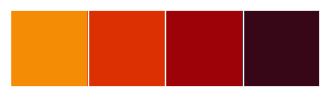

In [217]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

monocrome_hot = ["#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
monochrome_hot_palette = sns.color_palette(palette=monocrome_hot[::-2])[1:] #sns.husl_palette()

sns.palplot(monochrome_hot_palette)


#### UPDRS

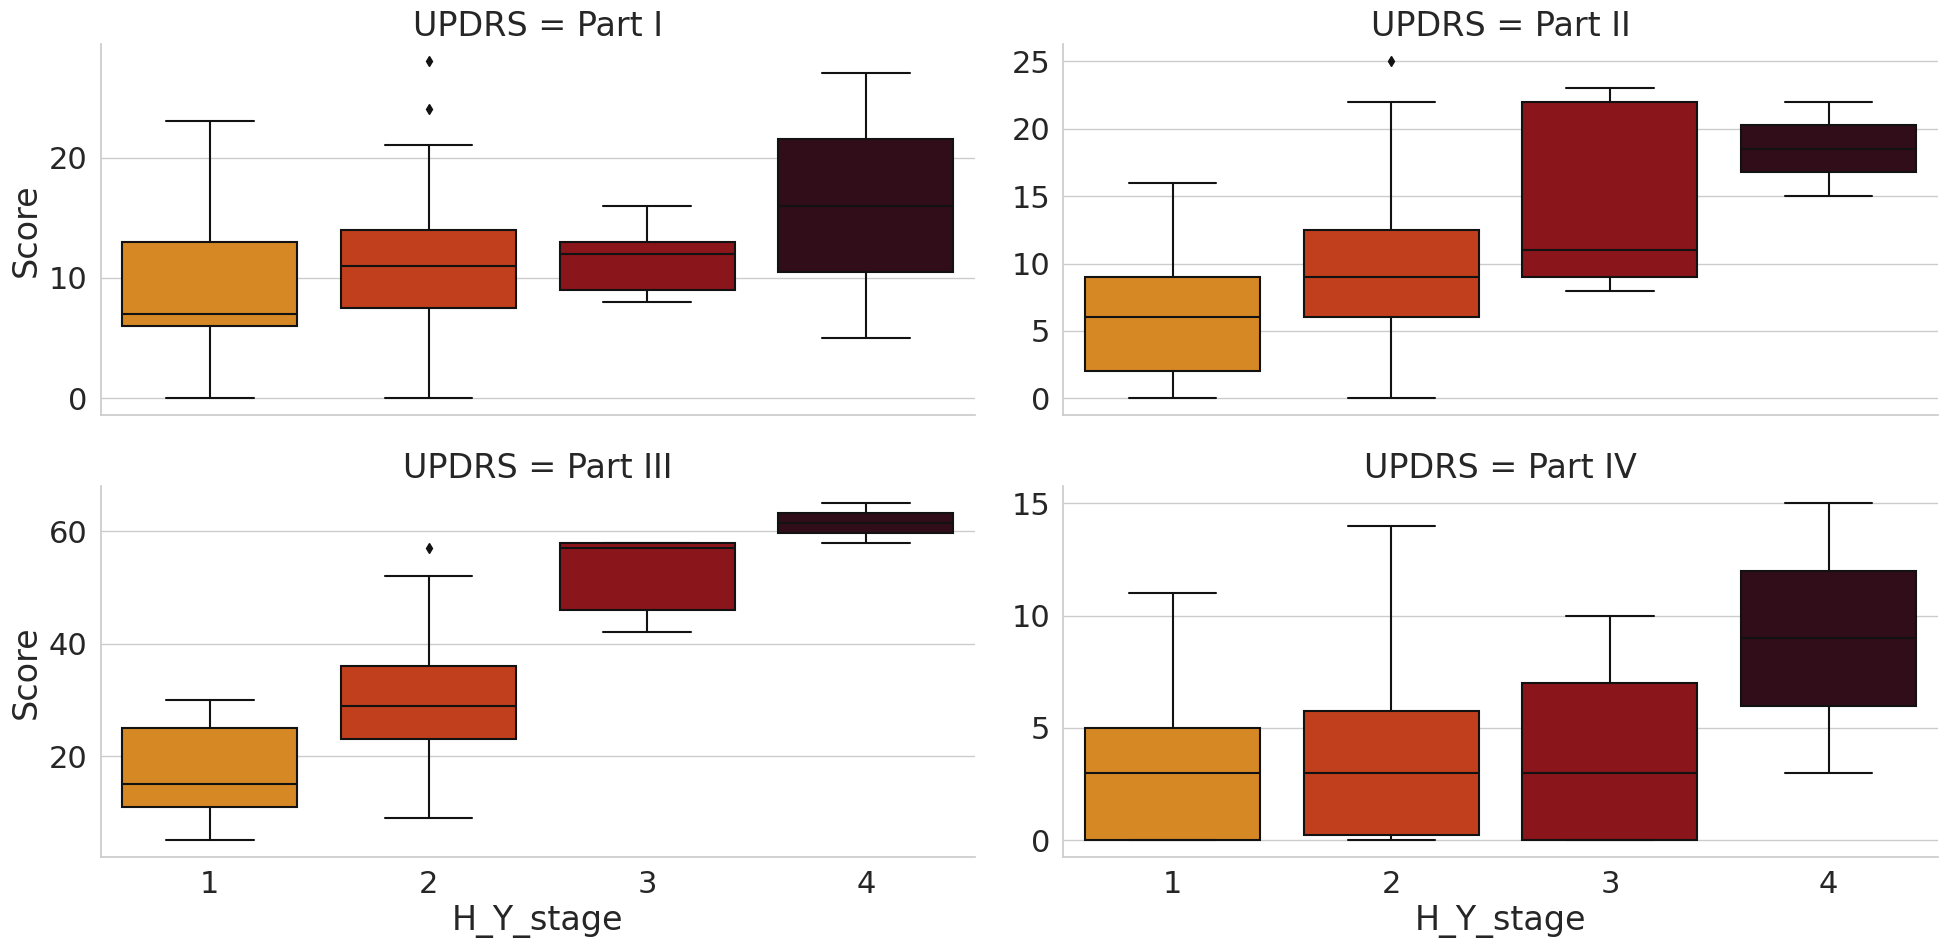

In [218]:
updrs_cols_dict = {
    "Hoehn and Yahr Stage: ":'H_Y_stage',
    'Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL)':'Part I',
    'Part II: Motor Aspects of Experiences of Daily Living (M-EDL)':'Part II',
    'Part III: Motor Examination':'Part III',
    'Part IV: Motor Complications':'Part IV',
}

H_Y_stage_dict = dict(zip(
    [
    '(2) Bilateral involvement without impairment of balance',
    '(3) Bilateral disease: mild to moderate disability with impaired postural reflexes; physically independent; needs assistance to recover from pull test',
    '(1) Unilateral involvement only, usually with minimal or no functional disability',
    '(0) Asymptomatic',
    '(4) Severely disabling disease; still able to walk or stand unassisted',
    np.nan], 
    
    ['2', '3', '1', '0', '4', "N/A"]
))

paper_updrs_df = paper_updrs_df.rename(columns=updrs_cols_dict)
plot_df = pd.merge(paper_updrs_df, hy_df, on=["participant_id","redcap_event_name"], how="left")
# paper_df["H_Y_stage"] = paper_df["H_Y_stage"].replace(H_Y_stage_dict)
# paper_df = paper_df[paper_df["H_Y_stage"]!="N/A"]

# Melt for plotting
plot_df = pd.melt(plot_df, id_vars=["participant_id","redcap_event_name","diagnosis_group_for_analysis","H_Y_stage"], 
                  value_vars=['Part I', 'Part II', 'Part III', 'Part IV'], 
                  var_name="UPDRS", value_name="Score")

# plot_df = plot_df[plot_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

stage_order = ['1', '2', '3', '4']

sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="Score",x="H_Y_stage", order=stage_order,
                    col="UPDRS", col_wrap=2, 
                    kind="box", palette=monochrome_hot_palette, 
                    data=plot_df, aspect=2, height=5, sharey=False)
    # g.set_xlabels("")
    # g.set_xticklabels("")

#### Moca

In [247]:
paper_moca_df.head()

,participant_id,diagnosis_group_for_analysis,redcap_event_name,moca_total,Did the participant receive +1 extra point for 12 years or less of education? Le participant a-t-il reçu +1 point supplémentaire pour 12 ans ou moins d'études?,moca_age,moca_age_diff,moca_age_diff_abs,cog_subgroup
0,MNI0056,PD,Baseline (Arm 1: C-OPN),21.0,Yes/Oui,79.06,-2.16,2.16,MCI
1,MNI0058,PD,Baseline (Arm 1: C-OPN),25.0,Yes/Oui,57.36,-0.84,0.84,MCI
2,MNI0079,PD,Baseline (Arm 1: C-OPN),26.0,No/Non,50.08,0.00,0.00,CN
3,MNI0103,PD,Baseline (Arm 1: C-OPN),20.0,No/Non,82.23,0.00,0.00,Dementia
4,MNI0109,PD,Baseline (Arm 1: C-OPN),30.0,No/Non,45.31,0.00,0.00,CN


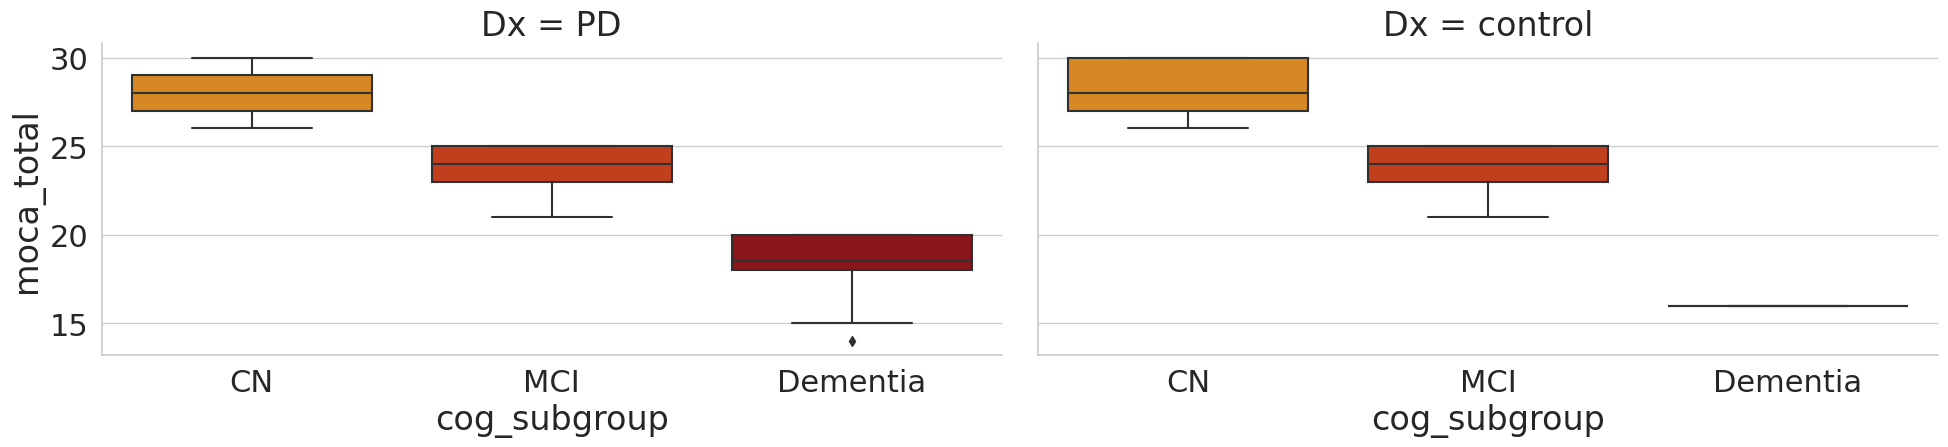

In [250]:
plot_df = paper_moca_df.copy()
plot_df = plot_df.rename(columns={"diagnosis_group_for_analysis":"Dx"})

hue_order = ["CN", "MCI", "Dementia"]
sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="moca_total",col="Dx", x=cog_subtype_col, order=hue_order,
                    kind="box", palette=monochrome_hot_palette, 
                    data=plot_df, aspect=2, height=5, sharey=True)